In [31]:
!pip install opencv-python matplotlib numpy

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels


In [32]:
!pip install tifffile

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels


In [33]:
import sys

In [34]:
import os
import tifffile
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

In [35]:
sys.path.append("/home/b858680f-9d82-4866-9261-e695c0b00008/CytoImageNet/cytoimagenet")

In [36]:
!pip install tqdm

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels


In [37]:
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels


In [38]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tqdm.notebook import tqdm

In [39]:
pretrained_model = EfficientNetB0(weights = 'imagenet', include_top=False, pooling='avg')
#loading pretrained model from cytoimagenet
print("✅ Model loaded successfully!")

✅ Model loaded successfully!


In [44]:
from skimage import filters, morphology, measure

In [45]:
#need to preprocess the images before they go into the model

#need to define the image as single or multichannel
def detect_file_type(filename):
    filename = filename.lower()

    if 'c1+2+3+4' in filename:
        return 'multi'
    elif any(f'c{i}' in filename for i in range(1,5)):
        return 'single'
    else:
        return 'unknown'

def load_single_channel(filepath):
    img = Image.open(filepath)
    img = img.convert("RGB")  # Convert grayscale/single channel to RGB automatically --> keeping greyscale for morphological features
    img = img.resize((224, 224))
    img = np.array(img)
    img = img / 255.0

    if img.ndim == 2:
        img = np.stack([img]*3, axis=-1)
    return img
        
'''
#function if the image is a single channel
def load_single_channel(filepath):
    img = tifffile.imread(filepath)

    if len(img.shape) == 2:  #looking for 2 dimension to clarify greyscale
        img = np.expand_dims(img, axis=-1) #adding channel axis

    #duplicate into 3 channels
    img = np.repeat(img, 3, axis=-1)
    
    # Resize to EfficientNet size
    img = cv2.resize(img, (224, 224))
    
    # Normalize for EfficientNet
    img = preprocess_input(img.astype(np.float32))
    
    return img
'''
def load_multi_channel(filepath):
    img = tifffile.imread(filepath)  # Load full multi-channel image

    # Just for debugging:
    print(f"Multi-channel image shape: {img.shape}")

    # If image has shape (224, 224, 9), keep first 3 channels
    if img.ndim == 3 and img.shape[-1] >= 3:
        img = img[..., :3]
    else:
        # If something unexpected happens
        img = np.stack([img]*3, axis=-1)

    # Resize (if needed, but looks like you're already 224x224)
  #  img = cv2.resize(img, (224, 224)) --> removing this step to add morphological features

    # Normalize for EfficientNet
   # img = img / 255.0 --> removing this step to add morphological features

    return img

'''
#function if the image is multiple channels
def load_multi_channel(filepath):
    img = tifffile.imread(filepath)
    
    # Handle channels-first format if necessary
    if img.shape[0] <= 4 and len(img.shape) == 3:
        img = np.moveaxis(img, 0, -1)
    
    # Take only first 3 channels for EfficientNet
    if img.shape[-1] > 3:
        img = img[:, :, :3]
    
    # If fewer than 3 channels somehow, pad by repeating channels
    elif img.shape[-1] < 3:
        img = np.repeat(img, 3, axis=-1)
    
    # Resize & Normalize
    img = cv2.resize(img, (224, 224))
    img = preprocess_input(img.astype(np.float32))
    
    return img

'''

#the image is now being read and preprocessed
def load_and_preprocess(filepath):
    filename = os.path.basename(filepath)
    file_type = detect_file_type(filename) #calling the file type function from above

    if file_type == 'multi':
        return load_multi_channel(filepath)
    elif file_type == 'single':
        return load_single_channel(filepath)
    else:
       raise ValueError(f"Cannot determine image type for file: {filename}")


def load_image_original(filepath):
    filename = os.path.basename(filepath).lower()

    if 'c1+2+3+4' in filename:
        img = tifffile.imread(filepath)
        if img.ndim == 3 and img.shape[-1] >= 3:
            img = img[..., :3]
        else:
            img = np.stack([img]*3, axis=-1)
    elif any(f'c{i}' in filename for i in range(1,5)):
        img = Image.open(filepath)
        img = img.convert("L")  # Keep grayscale for morphology
        img = np.array(img)
    else:
        raise ValueError(f"Cannot determine image type for file: {filename}")

    return img

def extract_morphology_features(img):
    if img.ndim ==3:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) #converting the image into greyscale

    img_blur = cv2.GaussianBlur(img, (5,5), 0) #adding blur to cancel noise

       # Otsu threshold
    thresh_value = filters.threshold_otsu(img_blur)
    binary = img_blur > thresh_value

    # Remove tiny objects
    cleaned = morphology.remove_small_objects(binary, min_size=100)

    # Label connected regions
    labeled = measure.label(cleaned)
    regions = measure.regionprops(labeled)

    # If no regions found, return zeros
    if len(regions) == 0:
        return [0, 0, 0, 0, 0, 0]

    region = max(regions, key=lambda r: r.area)

    area = region.area
    perimeter = region.perimeter
    circularity = 4 * np.pi * (area / (perimeter ** 2)) if perimeter > 0 else 0
    eccentricity = region.eccentricity
    solidity = region.solidity
    aspect_ratio = region.minor_axis_length / region.major_axis_length if region.major_axis_length > 0 else 0

    return [area, perimeter, circularity, eccentricity, solidity, aspect_ratio]
    

In [46]:
data_folder = 'Kemka Sample Data'

In [47]:
all_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith(('.tif', '.tiff'))]


In [48]:
features = [] #stores the features from each image
filenames = [] #stores the name of each image file
morph_features = []

for file in tqdm(all_files):
    try: 
        img = load_and_preprocess(file) #calls the preprocessing function
        if img.ndim == 2:
            img = np.stack([img]*3, axis=-1)
        elif img.shape[-1] == 1:
            img = np.repeat(img, 3, axis=-1)
        
        img_batch = np.expand_dims(img, axis=0) #adds a dimension
        feature_vector = pretrained_model.predict(img_batch) #the pretrained features will then come in and match pretrained to visible features
        features.append(feature_vector.flatten()) #flatten the feature and put it into the array
        filenames.append(os.path.basename(file))


        original_img = load_image_original(file)   # <-- this uses the full-resolution loader we made
        morph_feat = extract_morphology_features(original_img)
        morph_features.append(morph_feat)
    except Exception as e:
        print(f"Error processing {file}: {e}")

  0%|          | 0/120 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Multi-channel image shape: (1024, 1024, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Multi-channel image shape: (1945, 1946, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Multi-channel image shape: (1024, 1024, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 792ms/step
Multi-channel image shape: (1945, 1946, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Multi-channel image shape: (1024, 1024, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

In [54]:
features_df = pd.DataFrame(features, index=filenames)
features_df.to_csv("extracted_features.csv")

morph_features_df = pd.DataFrame(morph_features, index=filenames)
morph_features_df.to_csv("extracted_morph_features.csv")

print("✅ Features extracted and saved!")
print("Morph features are also extracted and saved!")

✅ Features extracted and saved!
Morph features are also extracted and saved!


In [67]:
df = pd.read_csv("extracted_morph_features.csv", index_col=0)
df.head()

0            1  \
MA47_BXP3_Cal27_NKcell_Experiment-3453-Orthogon...  223665.0  4410.842205   
MA47_BXP3_Cal27_NKcell_Experiment-3453-Orthogon...  199451.0  3538.228894   
MA47_BXP3_Cal27_NKcell_Experiment-3453-Orthogon...   37108.0  1817.387048   
MA47_BXP3_Cal27_NKcell_Experiment-3453-Orthogon...  105501.0  2625.366845   
MA47_BXP3_Cal27_NKcell_Experiment-3453-Orthogon...   98666.0  1186.898628   

                                                           2         3  \
MA47_BXP3_Cal27_NKcell_Experiment-3453-Orthogon...  0.144466  0.808924   
MA47_BXP3_Cal27_NKcell_Experiment-3453-Orthogon...  0.200205  0.814912   
MA47_BXP3_Cal27_NKcell_Experiment-3453-Orthogon...  0.141183  0.705029   
MA47_BXP3_Cal27_NKcell_Experiment-3453-Orthogon...  0.192347  0.444777   
MA47_BXP3_Cal27_NKcell_Experiment-3453-Orthogon...  0.880137  0.246244   

                                                           4         5  
MA47_BXP3_Cal27_NKcell_Experiment-3453-Orthogon...  0.827044  0.587914  
MA47_BXP3_Cal27_NKcell_Experiment-3453-Orthogon...  0.874172  0.579584  
MA47_BXP3_Cal27_NKcell_Experiment-3453-Orthogon...  0.845400  0.709178  
MA47_BXP3_Cal27_NKcell_Experiment-3453-Orthogon...  0.900003  0.895641  
MA47_BXP3_Cal27_NKcell_Experiment-3453-Orthogon...  0.993175  0.969208

In [68]:
print(df.shape)
#number of images, number of features

(120, 6)


In [69]:
df.describe()

0              1           2           3           4  \
count  1.200000e+02     120.000000  120.000000  120.000000  120.000000   
mean   1.906542e+05   20726.597374    0.269843    0.586049    0.839725   
std    2.577720e+05   57094.280607    0.272203    0.233119    0.161677   
min    1.200000e+02      41.556349    0.000101    0.131542    0.250493   
25%    9.089725e+04    1458.594849    0.041390    0.392273    0.791801   
50%    1.085455e+05    2567.284107    0.173970    0.521941    0.898196   
75%    1.679235e+05    5631.027413    0.401753    0.815139    0.954549   
max    1.424343e+06  398534.616107    0.880137    0.980132    0.993498   

                5  
count  120.000000  
mean     0.746809  
std      0.212860  
min      0.198347  
25%      0.579265  
50%      0.852970  
75%      0.919847  
max      0.991311

/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na opti

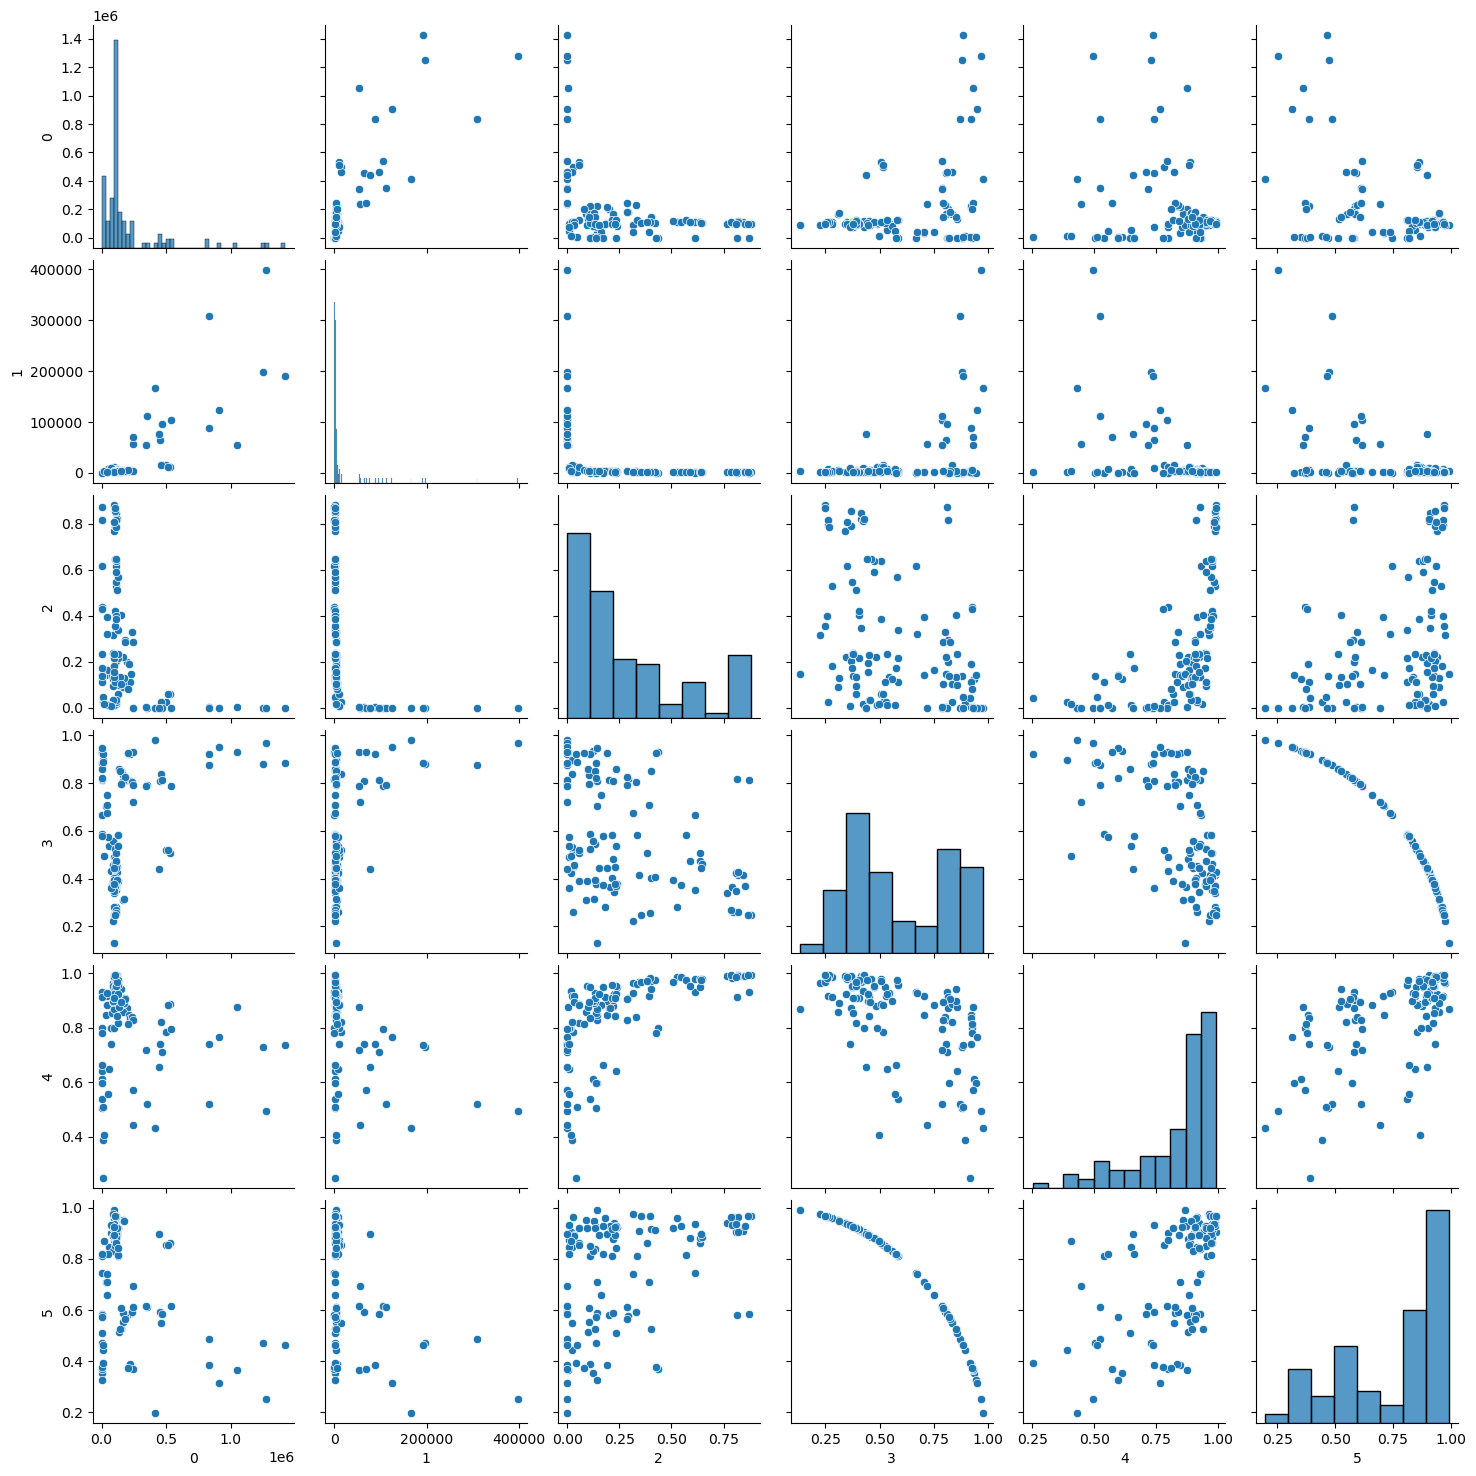

In [70]:
#print(df.isna().sum().sum())
import seaborn as sns
sns.pairplot(df)
plt.show()

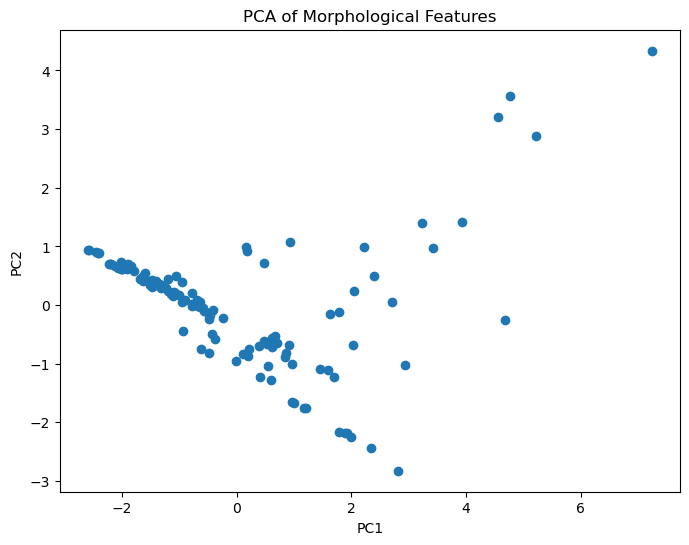

/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/joblib/externals/loky/backend/context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/joblib/externals/loky/backend/context.py", line 217, in _count_physical_cores
    raise ValueError(
/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of 

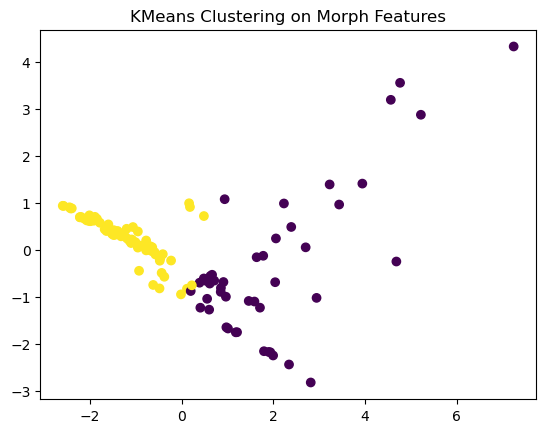

In [72]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


scaler = StandardScaler()
scaled_morph = scaler.fit_transform(df)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_morph)

plt.figure(figsize=(8,6))
plt.scatter(pca_result[:,0], pca_result[:,1])
plt.title("PCA of Morphological Features")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# Try clustering into 3 groups (just an example, can adjust)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(scaled_morph)

# Plot PCA again, colored by cluster
kmeans = KMeans(n_clusters=2)
labels = kmeans.fit_predict(scaled_morph)

# Visualize on PCA
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap='viridis')
plt.title("KMeans Clustering on Morph Features")
plt.show()

In [73]:
df['Cluster'] = kmeans.labels_
df['Filename'] = filenames
df.groupby('Cluster').count()


0   1   2   3   4   5  Filename
Cluster                                  
0        46  46  46  46  46  46        46
1        74  74  74  74  74  74        74

In [74]:
for cluster_num in df['Cluster'].unique():
    print(f"Cluster {cluster_num}:")
    print(df[df['Cluster'] == cluster_num]['Filename'])
    print("\n")

Cluster 0:
MA47_BXP3_Cal27_NKcell_Experiment-3453-Orthogonal Projection-01_s20c1.tif          MA47_BXP3_Cal27_NKcell_Experiment-3453-Orthogo...
MA47_BXP3_Cal27_NKcell_Experiment-3453-Orthogonal Projection-01_s14c2.tif          MA47_BXP3_Cal27_NKcell_Experiment-3453-Orthogo...
MA47_BXP3_Cal27_NKcell_Experiment-3453-Orthogonal Projection-01_s17c3.tif          MA47_BXP3_Cal27_NKcell_Experiment-3453-Orthogo...
MA47_BXP3_Cal27_NKcell_Experiment-3453-Orthogonal Projection-01_s13c4.tif          MA47_BXP3_Cal27_NKcell_Experiment-3453-Orthogo...
MA47_BXP3_Cal27_NKcell_Experiment-3453-Orthogonal Projection-01_s06c1+2+3+4.tif    MA47_BXP3_Cal27_NKcell_Experiment-3453-Orthogo...
MA47_BXP3_Cal27_NKcell_Experiment-3453-Orthogonal Projection-01_s12c4.tif          MA47_BXP3_Cal27_NKcell_Experiment-3453-Orthogo...
MA47_BXP3_Cal27_NKcell_Experiment-3453-Orthogonal Projection-01_s06c3.tif          MA47_BXP3_Cal27_NKcell_Experiment-3453-Orthogo...
MA47_BXP3_Cal27_NKcell_Experiment-3453-Orthogonal Projecti

In [80]:
print(df.dtypes)

0           float64
1           float64
2           float64
3           float64
4           float64
5           float64
Cluster       int32
Filename     object
cluster       int32
dtype: object


In [81]:
df['cluster'] = labels
numeric_df = df.drop(columns=['Filename'])

# Now group only on numeric data
cluster_summary = numeric_df.groupby('cluster').mean()

# Show the result
display(cluster_summary)

0             1         2         3         4         5  \
cluster                                                                        
0        314682.695652  49035.526161  0.110494  0.833663  0.705012  0.518676   
1        113555.418919   3129.155156  0.368898  0.432127  0.923466  0.888621   

         Cluster  
cluster           
0            0.0  
1            1.0

In [107]:
import os
import shutil

# Create folders for each cluster
for cluster_num in df['Cluster'].unique():
    cluster_folder = f"Cluster_{cluster_num}"
    os.makedirs(cluster_folder, exist_ok=True)

# Copy images into their cluster folders
for index, row in df.iterrows():
    src_path = os.path.join('Kemka Sample Data', row['Filename'])  # adjust path if needed
    dst_path = os.path.join(f"Cluster_{row['Cluster']}", row['Filename'])
    
    shutil.copy(src_path, dst_path)

print("✅ Images sorted into cluster folders!")

✅ Images sorted into cluster folders!


In [18]:
!pip install pyradiomics

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels
  Using cached pyradiomics-3.1.0.tar.gz (34.5 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Discarding https://files.pythonhosted.org/packages/03/c1/20fc2c50ab1e3304da36d866042a1905a2b05a1431ece35448ab6b4578f2/pyradiomics-3.1.0.tar.gz (from https://pypi.org/simple/pyradiomics/): Requested pyradiomics from https://files.pythonhosted.org/packages/03/c1/20fc2c50ab1e3304da36d866042a1905a2b05a1431ece35448ab6b4578f2/pyradiomics-3.1.0.tar.gz has inconsistent version: expected '3.1.0', but metadata has '3.0.1a1'
  Using cached pyradiomics-3.0.1-cp310-cp310-linux_x86_64.whl
  Using cached simpleitk-2.5.2-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (7.2 kB)
  Using cached pykwalify-1.8.0-py2.py3-none-any.whl.metadata (5.3 kB)
  Using cached docopt-0.6.2-py2.py3-non

In [20]:
from radiomics import featureextractor

extractor = featureextractor.RadiomicsFeatureExtractor()
print(extractor.enabledFeatures)

ImportError: cannot import name 'getFeatureClasses' from 'radiomics' (/home/b858680f-9d82-4866-9261-e695c0b00008/.local/lib/python3.10/site-packages/radiomics/__init__.py)